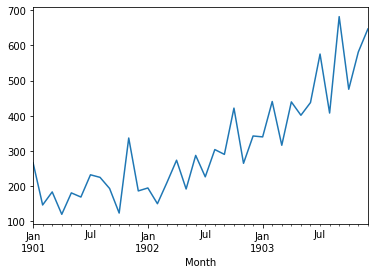

In [1]:
# load and plot dataset
from pandas import read_csv
# from pandas import datetime
from matplotlib import pyplot
from datetime import datetime

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array
from sklearn.model_selection import ParameterGrid


# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
series = series.squeeze()

# summarize first few rows
# print(series)

# line plot
series.plot()
pyplot.show()



In [ ]:
# grid search ets models for monthly shampoo sales
# https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

# https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7



# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p, use_boxcox=b)
	# model = ExponentialSmoothing(history, trend=t, seasonal=s, seasonal_periods=p, use_boxcox=b)

	# fit model
	# model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	model_fit = model.fit(optimized=True, remove_bias=r)

	# make one step forecast
	yhat = model_fit.predict(start = len(history), end = len(history))
	# print(yhat)

	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# print("train: ", train)
	# print("test: ", test)

	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# print("history: ", history)
		# print("predictions: ", predictions)

	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# print(key)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg, debug=True) for cfg in cfg_list]
	# remove empty results
	
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]  # Trend
	# t_params = ['mul']  # Trend

	# d_params = [True, False] #Damped
	d_params = [False] #Damped


	s_params = [None] #['add', 'mul', None] Seasonal
	p_params = seasonal # Seasonal Periods

	b_params = [True, False] #Box-Cox Transform
	# b_params = [False] #Box-Cox Transform

	r_params = [True, False] #Remove Bias
	# r_params = [False] #Remove Bias

	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

if __name__ == '__main__':
	# load dataset
	series = read_csv('shampoo.csv', header=0, index_col=0)
	data = series.values
	# data split (15%-test)
	n_test = int(len(data) * 0.15)
	print("test size = %d" %n_test)
	# model configs
	cfg_list = exp_smoothing_configs()
	# print(cfg_list)
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test, parallel=False)
	# print(scores)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

In [43]:
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
# https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import numpy as np
import pandas as pd


df = pd.read_excel('2022_HiMCM_Data-B-co2.xlsx',sheet_name="origin", index_col="Year", parse_dates=True)
# year = df['Year']
year = df.index
ppm = df['PPM'].to_numpy()
degree = df["Degree"].to_numpy()


input = ppm

dec_df = pd.DataFrame(
    data={'PPM': input}, 
    index=pd.date_range(start = str(year[0]),freq='Y', periods=len(year))  #freq="AS-JAN"
)

print(dec_df)

df_ppm = df.loc[:,['PPM']]
# print(df_ppm)
df_degree = df.iloc[18:,1]
# print(df_degree)

pyplot.rcParams["figure.figsize"] = [10, 10]

# Decompose and plot
result = seasonal_decompose(df_ppm, model='additive')
# result.plot()

result = seasonal_decompose(df_ppm, model='multiplicative')
# result.plot()

pyplot.show()



               PPM
1959-12-31  315.98
1960-12-31  316.91
1961-12-31  317.64
1962-12-31  318.45
1963-12-31  318.99
...            ...
2017-12-31  406.76
2018-12-31  408.72
2019-12-31  411.66
2020-12-31  414.24
2021-12-31  416.45

[63 rows x 1 columns]


In [101]:
df_holt = dec_df

#split data with trainx (90%) and testx(10%)
trainsize = int(len(df_holt)*0.70)
print(trainsize)
trainX = df_holt.iloc[:trainsize]
testX = df_holt.iloc[trainsize:]


44


In [97]:
# Double Exponential Smoothing (DES,des)
# https://michael-fuchs-python.netlify.app/2020/10/23/time-series-analysis-smoothing-methods/
# https://michael-fuchs-python.netlify.app/2020/10/23/time-series-analysis-smoothing-methods/#double-exponential-smoothing
from sklearn import metrics



param_grid_des = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 
                  'smoothing_trend':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
                  'damping_trend': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
                  # 'use_boxcox':[True, False],
                #   'remove_bias':[True, False],
                  'damped': [True, False],
                #   'trend':[True, False]
                  }
pg_des = list(ParameterGrid(param_grid_des))
# print(pg_des)

colum = [
        'smoothing_level', 
        'smoothing_trend', 
        'damping_trend', 
        # 'remove_bias',
        'damped', 
        # 'trend',
        'RMSE',
        'R²']

df_results_des  = pd.DataFrame(columns=colum)



# search parameters...
for a,b in enumerate(pg_des):
    smoothing_level = b.get('smoothing_level')
    smoothing_trend = b.get('smoothing_trend')
    damping_trend = b.get('damping_trend')
    # bias = b.get('remove_bias')
    damped = b.get('damped')
    # trend = b.get('trend')
    
    holtmodel = Holt(df_holt, damped_trend=damped)    
    fit_Holt = holtmodel.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, damping_trend=damping_trend, optimized=False)
    
    fcst_gs_pred_Holt = fit_Holt.forecast(len(testX))
    
    df_pred = pd.DataFrame(fcst_gs_pred_Holt, columns=['Forecasted_result'])

    RMSE = np.sqrt(metrics.mean_squared_error(testX, df_pred.Forecasted_result))
    r2 = metrics.r2_score(testX, df_pred.Forecasted_result)


    new_row = pd.Series({'smoothing_level':smoothing_level, 'smoothing_trend':smoothing_trend, 'damping_trend':damping_trend, 'damped':damped,  'RMSE':RMSE, 'R²':r2})
    df_results_des = pd.concat([df_results_des, new_row.to_frame().T], ignore_index=True)

    
    


df_results_des.sort_values(by=['RMSE','R²']).head(10)

31


,smoothing_level,smoothing_trend,damping_trend,damped,RMSE,R²
0,0.1,0.1,0.1,True,23.612929,-0.572243
1,0.1,0.2,0.1,True,23.742811,-0.589586
81,0.1,0.1,0.2,True,23.778617,-0.594384
2,0.1,0.3,0.1,True,23.871524,-0.606868
162,0.1,0.1,0.3,True,23.994272,-0.623435
3,0.1,0.4,0.1,True,23.99905,-0.624082
82,0.1,0.2,0.2,True,24.069343,-0.63361
4,0.1,0.5,0.1,True,24.125371,-0.641224
5,0.1,0.6,0.1,True,24.250474,-0.658289
243,0.1,0.1,0.4,True,24.285754,-0.663118


  smoothing_level smoothing_trend damping_trend damped       RMSE        R²
0             0.1             0.1           0.1   True  23.612929 -0.572243
                              Holt Model Results                              
Dep. Variable:                    PPM   No. Observations:                   44
Model:                           Holt   SSE                             10.604
Optimized:                       True   AIC                            -54.611
Trend:                 Multiplicative   BIC                            -47.474
Seasonal:                        None   AICC                           -52.341
Seasonal Periods:                None   Date:                 Wed, 16 Nov 2022
Box-Cox:                        False   Time:                         23:01:26
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
----------------------------------------------------------

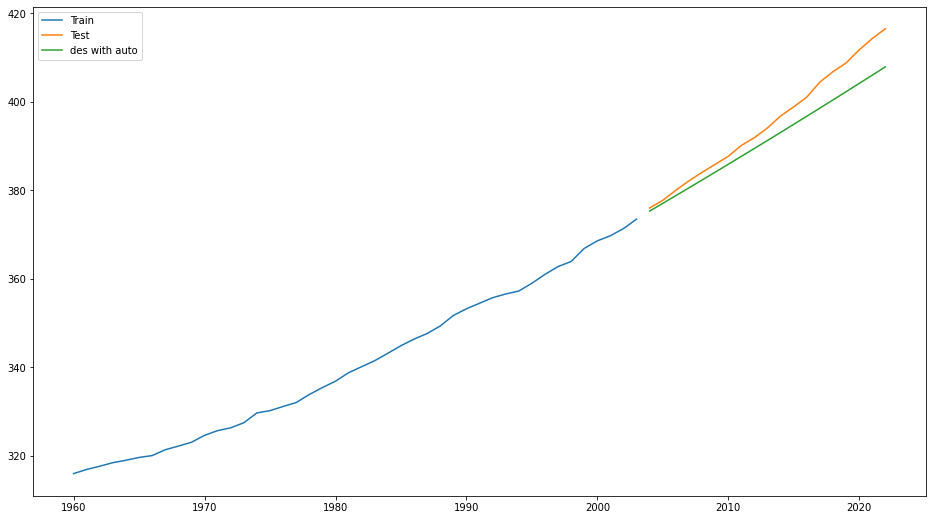

In [127]:
# Time Series in Python — Exponential Smoothing vs ARIMA processes
# https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

best_values_des = df_results_des.sort_values(by=['RMSE']).head(1)
print(best_values_des)

best_smoothing_level = best_values_des['smoothing_level'].iloc[0]
best_smoothing_trend = best_values_des['smoothing_trend'].iloc[0]
best_damping_trend   = best_values_des['damping_trend'].iloc[0]
best_damped = best_values_des['damped'].iloc[0]


# DES = Holt(trainX,damped=damped_setting_DES)
# fit_Holt = DES.fit(smoothing_level=smoothing_level_value_DES, smoothing_slope=smoothing_slope_value_DES, 
                #    damping_slope=damping_slope_value_DES ,optimized=False)

DES = Holt(trainX,  damped_trend=best_damped)    
DESfit = DES.fit(smoothing_level=best_smoothing_level, smoothing_trend=best_smoothing_trend, damping_trend=best_damping_trend, optimized=False)
# print(DESfit.summary())
fcst_gs_pred_Holt = DESfit.forecast(len(testX))

# print(trainX)
# print(testX)


DESautofit = Holt(trainX, exponential=True,damped_trend=False, initialization_method='estimated').fit(optimized=True,use_brute=True,method='ls', remove_bias=True)
print(DESautofit.summary())
fcst_gs_pred_Holt_auto = DESautofit.forecast(len(testX))
# print(fcst_gs_pred_Holt_auto)



pyplot.rcParams["figure.figsize"] = [16,9]
pyplot.plot(trainX, label='Train')
pyplot.plot(testX, label='Test')
# pyplot.plot(fcst_gs_pred_Holt, label='des with custom grid search')
pyplot.plot(fcst_gs_pred_Holt_auto, label='des with auto')
pyplot.legend(loc='best')
pyplot.show()


In [ ]:



df_ppm.plot(figsize=(15,10))
# modelfit = ExponentialSmoothing(df_ppm, trend="add", damped_trend=True, seasonal=None, use_boxcox=True).fit(optimized=True,use_brute=True, remove_bias=False)
modelfit = Holt(df_ppm, exponential="mul", damped_trend=False ).fit(optimized=True,use_brute=True,remove_bias=False)

print(modelfit.summary())
# print(modelfit.fittedvalues)
# print(modelfit.fittedfcast)
# print(modelfit.fcastvalues)
print(modelfit.forecast())

predicts = modelfit.forecast(60)
# print(predicts)
predicts.plot()




# modelfit.for
# make one step forecast
# yhat = model_fit.predict(start = len(history), end = len(history))


In [ ]:
# Importing library
import qrcode
 
# Data to be encoded
data = 'my phone #### '
 
# Encoding data using make() function
img = qrcode.make(data)
 
# Saving as an image file
img.save('MyQRCode1.png')

In [ ]:
# Importing library
import qrcode
 
# Data to encode
data = "朱韵淇"
 
# Creating an instance of QRCode class
qr = qrcode.QRCode(version = 1,
                   box_size = 10,
                   border = 5)
 
# Adding data to the instance 'qr'
qr.add_data(data)
 
qr.make(fit = True)
img = qr.make_image(fill_color = 'red',
                    back_color = 'white')
 
img.save('MyQRCode2.png')

In [ ]:
# import modules
import qrcode
from PIL import Image
 
# taking image which user wants
# in the QR code center
Logo_link = 'MyQRCode2.png'
 
logo = Image.open(Logo_link)
 
# taking base width
basewidth = 100
 
# adjust image size
wpercent = (basewidth/float(logo.size[0]))
hsize = int((float(logo.size[1])*float(wpercent)))
logo = logo.resize((basewidth, hsize), Image.ANTIALIAS)
QRcode = qrcode.QRCode(
    error_correction=qrcode.constants.ERROR_CORRECT_H
)
 
# taking url or text
url = 'https://www.geeksforgeeks.org/'
url = '蒋韵涵'

 
# adding URL or text to QRcode
QRcode.add_data(url)
 
# generating QR code
QRcode.make()
 
# taking color name from user
QRcolor = 'Green'
 
# adding color to QR code
QRimg = QRcode.make_image(
    fill_color=QRcolor, back_color="white").convert('RGB')
 
# set size of QR code
pos = ((QRimg.size[0] - logo.size[0]) // 2,
       (QRimg.size[1] - logo.size[1]) // 2)
QRimg.paste(logo, pos)
 
# save the QR code generated
QRimg.save('MyQRCode3.png')
 
print('QR code generated!')